In [43]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import math

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna

import eli5
from eli5.sklearn import PermutationImportance

In [44]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../../data/train_merge_0122_01(UTF-8)_final.csv'
test_path  = '../../data/test_merge_0122_01(UTF-8)_final.csv'
goldwe_path = '../../data/korea_interest_rate.xlsx'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
goldwe = pd.read_excel(goldwe_path)

In [45]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])     # 하나의 데이터로 만들어줍니다.

In [46]:
concat

,시군구,번지,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,...,산책코스총길이,산책생활지수,산책생활지수명,산책평가점수,생태공원코스수,생태공원코스총길이,생태공원생활지수,생태공원생활지수명,생태공원평가점수,is_test
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,서울특별시 강남구 개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,신내우디안1단지,84.65,202307,19,13,2014,신내역로1길 85,20230801.0,...,0.0,5.0,하위권,0.0,0.0,0.0,5.0,하위권,0.0,1
9268,서울특별시 중랑구 신내동,816,신내우디안1단지,84.62,202307,25,12,2014,신내역로1길 85,NaN,...,0.0,5.0,하위권,0.0,0.0,0.0,5.0,하위권,0.0,1
9269,서울특별시 중랑구 신내동,816,신내우디안1단지,101.65,202308,27,12,2014,신내역로1길 85,NaN,...,0.0,5.0,하위권,0.0,0.0,0.0,5.0,하위권,0.0,1
9270,서울특별시 중랑구 신내동,816,신내우디안1단지,84.94,202309,2,18,2014,신내역로1길 85,NaN,...,0.0,5.0,하위권,0.0,0.0,0.0,5.0,하위권,0.0,1


In [47]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 78 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   시군구                1128094 non-null  object 
 1   번지                 1128094 non-null  object 
 2   아파트명               1125958 non-null  object 
 3   전용면적               1128094 non-null  float64
 4   계약년월               1128094 non-null  int64  
 5   계약일                1128094 non-null  int64  
 6   층                  1128094 non-null  int64  
 7   건축년도               1128094 non-null  int64  
 8   도로명                1128094 non-null  object 
 9   해제사유발생일            6195 non-null     float64
 10  거래유형               41643 non-null    object 
 11  중개사소재지             38513 non-null    object 
 12  k-단지분류             250821 non-null   object 
 13  k-세대타입(분양형태)       251969 non-null   object 
 14  k-복도유형             251640 non-null   object 
 15  k-난방방식             251969 non-null 

In [48]:
# 숲세권 정보 결측치 처리 -> 정보가 없는 데이터이기 떄문에 모두 0으로 처리
concat["숲세권생활지수"] = concat["숲세권생활지수"].fillna(0)
concat["숲세권생활지수명"] = concat["숲세권생활지수명"].fillna("정보없음")
concat["숲세권평가점수"] = concat["숲세권평가점수"].fillna(0)

# 지천코스 정보 결측치 처리 -> 정보가 없는 데이터이기 떄문에 모두 0으로 처리
concat["지천코스수"] = concat["지천코스수"].fillna(0)
concat["지천코스총길이"] = concat["지천코스총길이"].fillna(0)
concat["지천생활지수"] = concat["지천생활지수"].fillna(0)
concat["지천생활지수명"] = concat["지천생활지수명"].fillna("정보없음")
concat["지천평가점수"] = concat["지천평가점수"].fillna(0)

# 공원 정보 결측치 처리 -> 정보가 없는 데이터이기 떄문에 모두 0으로 처리
concat["공원수"] = concat["공원수"].fillna(0)
concat["공원총면적"] = concat["공원총면적"].fillna(0)
concat["도시공원생활지수"] = concat["도시공원생활지수"].fillna(0)
concat["도시공원생활지수명"] = concat["도시공원생활지수명"].fillna("정보없음")
concat["도시공원평가점수"] = concat["도시공원평가점수"].fillna(0)

# 산책코스 정보 결측치 처리 -> 정보가 없는 데이터이기 떄문에 모두 0으로 처리
concat["산책코스수"] = concat["산책코스수"].fillna(0)
concat["산책코스총길이"] = concat["산책코스총길이"].fillna(0)
concat["산책생활지수"] = concat["산책생활지수"].fillna(0)
concat["산책생활지수명"] = concat["산책생활지수명"].fillna("정보없음")
concat["산책평가점수"] = concat["산책평가점수"].fillna(0)

# 생태공원 정보 결측치 처리 -> 정보가 없는 데이터이기 떄문에 모두 0으로 처리
concat["생태공원코스수"] = concat["생태공원코스수"].fillna(0)
concat["생태공원코스총길이"] = concat["생태공원코스총길이"].fillna(0)
concat["생태공원생활지수"] = concat["생태공원생활지수"].fillna(0)
concat["생태공원생활지수명"] = concat["생태공원생활지수명"].fillna("정보없음")
concat["생태공원평가점수"] = concat["생태공원평가점수"].fillna(0)

In [49]:
# '아파트명'이 '힐스테이트 서초 젠트리스'인 행의 '번지', '본번', '부번' 업데이트
concat.loc[concat['아파트명'] == '힐스테이트 서초 젠트리스', '번지'] = '557'
concat.loc[concat['아파트명'] == '힐스테이트 서초 젠트리스', '본번'] = 557
concat.loc[concat['아파트명'] == '힐스테이트 서초 젠트리스', '부번'] = 0

# '아파트명'이 '서초포레스타2단지'인 행의 '번지', '본번', '부번' 업데이트
concat.loc[concat['아파트명'] == '서초포레스타2단지', '번지'] = '384'
concat.loc[concat['아파트명'] == '서초포레스타2단지', '본번'] = 384
concat.loc[concat['아파트명'] == '서초포레스타2단지', '부번'] = 0

# 도로명을 기준으로 그룹화하고, 각 그룹 내에서 '아파트명'의 결측치를 채웁니다.
concat['아파트명'] = concat.groupby('도로명')['아파트명'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# 각 행별로 '도로명'에 '구로동로'가 포함 된다면 '아파트명'의 결측치를 해당 행의 도로명으로 대체(아파트명이 실제로 없기에 도로명으로 대체)
concat['아파트명'] = concat.apply(lambda row: row['도로명'] if (row['시군구'] == '서울특별시 구로구 구로동' and pd.isna(row['아파트명']) and ('구로동로' in row['도로명'] or '도림로' in row['도로명'] or '디지털로' in row['도로명'])) else row['아파트명'], axis=1)

# 아파트명 직접 대체
concat.loc[concat['도로명'] == '천호대로77다길 11-6', '아파트명'] = '해오름아파트'
concat.loc[concat['도로명'] == '동호로11마길 20-8', '아파트명'] = '성민아트'
concat.loc[concat['도로명'] == '여의대방로62길 24', '아파트명'] = '효성아파트'
concat.loc[concat['도로명'] == '국사봉1길 18', '아파트명'] = '상진빌딩'
concat.loc[concat['도로명'] == '동호로11바길 30-8', '아파트명'] = '석종아파트'
concat.loc[concat['도로명'] == '신수로 89', '아파트명'] = '신수동 자이언트 아파트'
concat.loc[concat['도로명'] == '양재대로71길 2-11', '아파트명'] = '올림픽아트빌'
concat.loc[concat['도로명'] == '청계천로 295', '아파트명'] = '동대문신발상가'
concat.loc[concat['도로명'] == '대학로7길 15-4', '아파트명'] = '연건동아파트'
concat.loc[concat['도로명'] == '강남대로27길 7-14', '아파트명'] = '한일인텔빌라'
concat.loc[concat['도로명'] == '명륜2길 9-14', '아파트명'] = '명륜2길 9-14'
concat.loc[concat['도로명'] == '동호로5길 12', '아파트명'] = '다다유크레스'
concat.loc[concat['도로명'] == '증산로23길 8-8', '아파트명'] = '우일아파트'
concat.loc[concat['도로명'] == '낙산성곽동길 35-1', '아파트명'] = '낙산성곽동길 35-1'
concat.loc[concat['도로명'] == '서리풀길 14', '아파트명'] = 'callia vill'
concat.loc[concat['도로명'] == '효령로 200', '아파트명'] = '효령로 200'
concat.loc[concat['도로명'] == '화곡로 176-5', '아파트명'] = '화곡로 176-5'
concat.loc[concat['도로명'] == '광나루로12길 5', '아파트명'] = '광나루로12길 5'
concat.loc[concat['도로명'] == '개운사길 83-15', '아파트명'] = '개운사길 83-15'
concat.loc[concat['도로명'] == '도곡로93길 23', '아파트명'] = '대치 르엘'
concat.loc[concat['도로명'] == '까치산로14길 26-13', '아파트명'] = '힐탑아파트'
concat.loc[concat['도로명'] == '양천로 677', '아파트명'] = '염창하이츠빌딩'
concat.loc[concat['도로명'] == '천호대로118길 10', '아파트명'] = '천호대로118길 10'
concat.loc[concat['도로명'] == '난계로15길 36-6', '아파트명'] = '난계로15길 36-6'
concat.loc[concat['도로명'] == '난계로15길 36-8', '아파트명'] = '난계로15길 36-8'
concat.loc[concat['도로명'] == '이문로35아길 16', '도로명'] = '이문로16길 35' # 잘못된 도로명 주소 수정
concat.loc[concat['도로명'] == '이문로16길 35', '아파트명'] = '이문로16길 35'
concat.loc[concat['도로명'] == '마조로1길 45', '아파트명'] = '아파트'
concat.loc[concat['도로명'] == '성지3길 7', '아파트명'] = '성지3길 7'

In [50]:
concat["아파트명"].fillna(concat[concat["아파트명"].isna()]["도로명"], inplace=True)
del concat["본번"]
del concat["부번"]

In [51]:
# concat[concat[["k-전체세대수", "k-전용면적별세대현황60이하", "k-전용면적별세대현황6085이하", "k-85135이하", "k-135초과"]].isna().sum(axis=1)==1][["k-전체세대수", "k-전용면적별세대현황60이하", "k-전용면적별세대현황6085이하", "k-85135이하", "k-135초과"]]

In [52]:
concat["평수"] = concat["전용면적"] * 0.3025
concat["평수"] = concat["평수"].astype(int)

In [53]:
concat[~concat["전세가율"].isna()][["구", "동", "계약년월", "전세가율"]].sort_values(by="계약년월")

,구,동,계약년월,전세가율
856690,강서구,방화동,201304,58.58
901237,영등포구,양평동4가,201304,53.86
901238,영등포구,양평동4가,201304,53.86
869223,노원구,상계동,201304,57.68
869229,노원구,상계동,201304,57.68
...,...,...,...,...
2710,금천구,시흥동,202309,57.55
2702,금천구,시흥동,202309,57.55
2701,금천구,시흥동,202309,57.55
7163,송파구,송파동,202309,45.26


In [54]:
concat["1평당target"] = concat["target"] / concat["평수"]
concat["1전용면적당target"] = concat["target"] / concat["전용면적"]

In [55]:
# 아파트-한강중심 하버사인 거리
lat1 = np.deg2rad(37.5104939)
lat2 = np.deg2rad(concat['좌표Y'])
lon1 = np.deg2rad(126.9817655)
lon2 = np.deg2rad(concat['좌표X'])
dlat = lat2 - lat1
dlon = lon1 - lon2
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
concat['아파트-한강거리'] = c * 6371 * 1000

In [56]:
# 아파트-서울중심 하버사인 거리
lat1 = np.deg2rad(37.5518911)
lat2 = np.deg2rad(concat['좌표Y'])
lon1 = np.deg2rad(126.9917937)
lon2 = np.deg2rad(concat['좌표X'])
dlat = lat2 - lat1
dlon = lon1 - lon2
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
concat['아파트-서울중심거리'] = c * 6371 * 1000

In [57]:
def distance_range(distance):
    if distance <= 1000:
        return "0~1km"
    elif distance <= 5000:
        return "1~5km"
    elif distance <= 10000:
        return "5~10km"
    elif distance <= 20000:
        return "10~20km"
    elif distance > 20000:
        return "20km 초과"
    else:
        return "NaN"

In [58]:
concat["아파트-한강거리범위"] = concat["아파트-한강거리"].apply(distance_range)
concat["아파트-서울중심거리범위"] = concat["아파트-서울중심거리"].apply(distance_range)

In [59]:
concat.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       '해제사유발생일', '거래유형', '중개사소재지', 'k-단지분류', 'k-세대타입(분양형태)', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황60이하', 'k-전용면적별세대현황6085이하', 'k-85135이하', 'k-135초과',
       '세대전기계약방법', '건축면적', '주차대수', '기타의무임대1234', '단지신청일', 'target', '구', '동',
       '전체주소명', '동아파트명', '유동인구', '아파트 지하철역 거리', '1차역세권', '2차역세권',
       '아파트 버스정류장 거리', '좌표X', '좌표Y', '아파트 한강대교 거리', '전세가율', '전체계약일자', '금리',
       '실질gdp', '명목gdp', '학군', '재개발개수', '학급수', '여당득표율', '법정동주소', '숲세권생활지수',
       '숲세권생활지수명', '숲세권평가점수', '지천코스수', '지천코스총길이', '지천생활지수', '지천생활지수명',
       '지천평가점수', '공원수', '공원총면적', '도시공원생활지수', '도시공원생활지수명', '도시공원평가점수', '산책코스수',
       '산책코스총길이', '산책생활지수', '산책생활지수명', '산책평가점수', '생태공원코스수', '생태공원코스총길이',
       '생태공원생활지수', '생태공원생활지수명', '생태공원평가점수', 'is_test', '평수', '1평당target',
       '1전용면적당target', '아파트-한강거리', '아파트-서울중심거리', '아파트-한강거리범위', '아파트-서울중심거리범위'],
      dtype='object')

In [60]:
train = concat.query('is_test==0')
test = concat.query('is_test==1')

gdp = pd.read_csv('../../data/1year_gdp.csv',encoding='cp949')

train['계약년월'] = train['계약년월'].astype(int)

contract_years = sorted([200612, 200703, 200706, 200709, 200712, 200803, 200806, 200809,
       200812, 200903, 200906, 200909, 200912, 201003, 201006, 201009,
       201012, 201103, 201106, 201109, 201112, 201203, 201206, 201209,
       201212, 201303, 201306, 201309, 201312, 201403, 201406, 201409,
       201412, 201503, 201506, 201509, 201512, 201603, 201606, 201609,
       201612, 201703, 201706, 201709, 201712, 201803, 201806, 201809,
       201812, 201903, 201906, 201909, 201912, 202003, 202006, 202009,
       202012, 202103, 202106, 202109, 202112, 202203, 202206, 202209,
       202212, 202303, 202306, 202309])

before = contract_years[0]

# 조건에 따라 'gdp' 값 대입
for contract_year in contract_years[1:]:
    condition = (train['계약년월'] > before) & (train['계약년월'] <= contract_year)
    gdp_values = gdp[gdp['CONTR_YEAR_MONTH'] == contract_year][['REAL_GDP','NOMINAL_GDP']].values
    train.loc[condition, ['실질GDP', '국민총생산']] = gdp_values
    before = contract_year

# 조건에 따라 'gdp' 값 대입
for contract_year in contract_years[1:]:
    condition = (test['계약년월'] > before) & (test['계약년월'] <= contract_year)
    gdp_values = gdp[gdp['CONTR_YEAR_MONTH'] == contract_year][['REAL_GDP','NOMINAL_GDP']].values
    test.loc[condition, ['실질GDP', '국민총생산']] = gdp_values
    before = contract_year

In [61]:
goldwe = pd.read_excel('../../data/korea_interest_rate.xlsx')

goldwe["CONTR"] = goldwe["변경일자_년"].astype(str) + goldwe["변경일자_월일"].map(lambda x : x[:2] + x[4:6])
g01 = goldwe.sort_values('CONTR')
g01['날짜열_1년후'] = pd.to_datetime(g01['CONTR']) + pd.DateOffset(years=1)
g01['날짜열_11개월후'] = pd.to_datetime(g01['CONTR']) + pd.DateOffset(months=11)
g01['날짜열_13개월후'] = pd.to_datetime(g01['CONTR']) + pd.DateOffset(months=13)
g02 = g01[['날짜열_11개월후', '기준금리']]
g03 = g01[['날짜열_1년후', '기준금리']]
g04 = g01[['날짜열_13개월후', '기준금리']]

g02.columns = ['날짜열_11개월후', "11개월전_금리"]
g03.columns = ['날짜열_1년후', "1년전금리"]
g04.columns = ['날짜열_13개월후', "13개월전_금리"]

g02['날짜열_11개월후_종료일'] = g02['날짜열_11개월후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)
g03['날짜열_1년후_종료일'] = g03['날짜열_1년후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)
g04['날짜열_13개월후_종료일'] = g04['날짜열_13개월후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)

make_date = train["전체계약일자"].reset_index()
make_date_test = test["전체계약일자"].reset_index()

make_date['CONTR'] = make_date['전체계약일자'].astype('str')
make_date_test['CONTR'] = make_date_test['전체계약일자'].astype('str')

m02 = pd.merge(make_date, g02, how = 'cross')
m03 = pd.merge(make_date, g03, how = 'cross')
m03_test = pd.merge(make_date_test, g03, how = 'cross')
m04 = pd.merge(make_date, g04, how = 'cross')

m02['CONTR'] = pd.to_datetime(m02['CONTR'])
m03['CONTR'] = pd.to_datetime(m03['CONTR'])
m03_test['CONTR'] = pd.to_datetime(m03_test['CONTR'])
m04['CONTR'] = pd.to_datetime(m04['CONTR'])

m02['현재와시작일차이'] = (m02['CONTR'] - m02['날짜열_11개월후']).dt.days
m02['현재와종료일차이'] = (m02['날짜열_11개월후_종료일'] - m02['CONTR']).dt.days
m02['체크'] = m02['현재와시작일차이']*m02['현재와종료일차이']

m03['현재와시작일차이'] = (m03['CONTR'] - m03['날짜열_1년후']).dt.days
m03['현재와종료일차이'] = (m03['날짜열_1년후_종료일'] - m03['CONTR']).dt.days
m03['체크'] = m03['현재와시작일차이']*m03['현재와종료일차이']

m03_test['현재와시작일차이'] = (m03_test['CONTR'] - m03_test['날짜열_1년후']).dt.days
m03_test['현재와종료일차이'] = (m03_test['날짜열_1년후_종료일'] - m03_test['CONTR']).dt.days
m03_test['체크'] = m03_test['현재와시작일차이']*m03_test['현재와종료일차이']

m04['현재와시작일차이'] = (m04['CONTR'] - m04['날짜열_13개월후']).dt.days
m04['현재와종료일차이'] = (m04['날짜열_13개월후_종료일'] - m04['CONTR']).dt.days
m04['체크'] = m04['현재와시작일차이']*m04['현재와종료일차이']

m02[m02['체크'] >= 0]

m03[m03['체크'] >= 0]
m03_test[m03_test['체크'] >= 0]

m04[m04['체크'] >= 0]

m02.set_index('index', inplace=True)

m03.set_index('index', inplace=True)
m03_test.set_index('index', inplace=True)

m04.set_index('index', inplace=True)
# train3 = pd.concat([train2, m02['11개월전_금리'][m02['체크'] >= 0]], axis = 1)

train = pd.concat([train, m03['1년전금리'][m03['체크'] >= 0]], axis = 1)
test = pd.concat([test, m03_test['1년전금리'][m03_test['체크'] >= 0]], axis = 1)

# train3 = pd.concat([train2, m04['13개월전_금리'][m04['체크'] >= 0]], axis = 1)

In [62]:
# test에 없는 데이터를 train에서 삭제

# # 정규표현식 패턴 생성
# excluded_apts = ['AirPalace', 'SRvill', '경동팰리스힐', '대길B', '썬앤빌', '재선주택', '코원']

# # go
# pattern = '|'.join(excluded_apts)

# # '열이름' 열에서 패턴이 있는지 확인하여 새로운 열 추가
# train['is_아파트'] = np.where(train['APT_NM'].str.contains(pattern), 1, 0)

# train = train[train['is_아파트'] == 0]

# train = train.drop(columns='is_아파트')

In [63]:
train['평수'] = train['평수'].astype('str')
test['평수'] = test['평수'].astype('str')
train['동아파트명'] = train['동'] + ' ' + train['아파트명']
test['동아파트명'] = test['동'] + ' ' + test['아파트명']
train['동아파트명+평수'] = train['동아파트명'] + ' ' + train['평수']
test['동아파트명+평수'] = test['동아파트명'] + ' ' + test['평수']

In [64]:
targets = [15000,19000,21500,24000,26000,
            27500,28750,30000,31500,33000,
            34250,35500,36750,37750,39000,
            40000,41000,42250,43500,44500,
            45500,46750,48000,49250,50250,
            51500,53000,54500,56000,57500,
            59000,60250,62000,64000,66000,
            68000,70250,72500,75000,77500,
            80000,83000,87000,91000,95000,
            99500,105000,111000,117500,125000,
            132000,140000,150000,162500,177500,
            190000,200000,220000,240000,260000,
            280000,300000,320000,340000,360000,
            380000,400000,425000,450000,500000,
            550000,600000,700000,800000,900000,
            1000000,1100000,1200000
            ]

# 새로운 feature '아파트명 평균가' 생성
train['동아파트명+평수-target평균'] = 0

for i in range(len(targets)):
    # 'APT_NM' 별 'target'의 평균 계산
    avg_target_by_apt = train.groupby('동아파트명+평수')['target'].mean()

    # 평균이 400000을 초과하는 'APT_NM'에 대한 조건 필터링
    selected_apt_names = avg_target_by_apt[avg_target_by_apt > targets[i]].index
    
    # 조건을 만족하는 행들에 대해 '아파트명 평균가'에 8이라는 값을 할당
    train.loc[train['동아파트명+평수'].isin(selected_apt_names), '동아파트명+평수-target평균'] = i
data = train[['동아파트명+평수-target평균','동아파트명+평수']].drop_duplicates()
test = pd.merge(test,data,how='left',on='동아파트명+평수')

In [65]:
# 거래유형, 중개사소재지, 단지분류, 세대타입, 전체동수, 전체세대수, 시행사, 연면적, 주거전용면적, 전용면적별세대현황60이하, 전용면적별세대현황6085이하, 85135이하, 135초과, 세대전기계약방법, 건축면적,기타의무임대1234, 단지신청일
# 결측치가 많아 채워넣을 수 없는 columns 삭제
concat = pd.concat([train, test])
concat.drop(['거래유형', '중개사소재지', 'k-단지분류', 'k-세대타입(분양형태)', 
             'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적', 'k-복도유형',
             'k-주거전용면적','k-전용면적별세대현황60이하', 'k-전용면적별세대현황6085이하', 'k-난방방식',
             'k-85135이하', 'k-135초과', '세대전기계약방법', '건축면적', '기타의무임대1234', 
             '단지신청일', '주차대수'], axis=1, inplace=True)
# 주차대수, 건설사는 채워넣을 수 있음

In [66]:
concat["도로명"] = concat["도로명"].str.split().str[0]

In [67]:
concat["해제사유발생여부"] = concat["해제사유발생일"].apply(lambda x: "0" if math.isnan(x) else "1")
del concat["해제사유발생일"]

In [68]:
concat = pd.merge(concat, concat.groupby(by="동아파트명+평수", as_index=False)["1평당target"].mean(), on="동아파트명+평수", how="left", suffixes=("", "_아파트별평균"))
concat = pd.merge(concat, concat.groupby(by="동아파트명+평수", as_index=False)["1전용면적당target"].mean(), on="동아파트명+평수", how="left", suffixes=("", "_아파트별평균"))

In [69]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 1128093
Data columns (total 71 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   시군구                  1128094 non-null  object 
 1   번지                   1128094 non-null  object 
 2   아파트명                 1128094 non-null  object 
 3   전용면적                 1128094 non-null  float64
 4   계약년월                 1128094 non-null  int64  
 5   계약일                  1128094 non-null  int64  
 6   층                    1128094 non-null  int64  
 7   건축년도                 1128094 non-null  int64  
 8   도로명                  1126883 non-null  object 
 9   target               1118822 non-null  float64
 10  구                    1128094 non-null  object 
 11  동                    1128094 non-null  object 
 12  전체주소명                1128094 non-null  object 
 13  동아파트명                1128094 non-null  object 
 14  유동인구                 1128094 non-null  int64  
 15

In [70]:
concat_201701 = concat[concat["계약년월"]>=201701]

In [71]:
concat_201701.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426864 entries, 0 to 1128093
Data columns (total 71 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   시군구                  426864 non-null  object 
 1   번지                   426864 non-null  object 
 2   아파트명                 426864 non-null  object 
 3   전용면적                 426864 non-null  float64
 4   계약년월                 426864 non-null  int64  
 5   계약일                  426864 non-null  int64  
 6   층                    426864 non-null  int64  
 7   건축년도                 426864 non-null  int64  
 8   도로명                  426723 non-null  object 
 9   target               417592 non-null  float64
 10  구                    426864 non-null  object 
 11  동                    426864 non-null  object 
 12  전체주소명                426864 non-null  object 
 13  동아파트명                426864 non-null  object 
 14  유동인구                 426864 non-null  int64  
 15  아파트 지하철역 거리     

In [72]:
concat_201701 = concat_201701[concat_201701['해제사유발생여부']=="0"]

In [73]:
concat_201701['전체계약일자'] = concat_201701['전체계약일자'].astype('category')

In [79]:
# 시군구, 아파트명, 계약일, 학급수

concat_201701.drop(['시군구', '아파트명', '계약일', '학급수', '금리', '해제사유발생여부', '아파트-한강거리범위', '아파트-서울중심거리범위', '국민총생산', '평수', '생태공원생활지수명', '생태공원평가점수',
                    '산책평가점수', '산책생활지수명', '도시공원평가점수', '도시공원생활지수명', '지천평가점수', '지천생활지수명', '숲세권평가점수', '숲세권생활지수명', '여당득표율', '법정동주소',
                    '실질gdp', '명목gdp', '동아파트명', '전체주소명', '계약일', '계약년월'], axis=1, inplace=True)
# 시군구, 아파트명, 계약일, 학급수

concat_201701.drop(['번지', '지천코스수', '공원총면적', '공원수', '산책코스수', '산책코스총길이', '생태공원코스수', '생태공원코스총길이', '1차역세권', '2차역세권'], axis=1, inplace=True)



In [86]:
cat_features = concat_201701.select_dtypes(include=['object']).columns.to_list()
print("== Categorical ==")
print(cat_features)
num_features = concat_201701.select_dtypes(exclude='object').columns.to_list()
print("== Numerical ==")
print(num_features)

== Categorical ==
[]
== Numerical ==
['전용면적', '층', '건축년도', '도로명', 'target', '구', '동', '유동인구', '아파트 지하철역 거리', '아파트 버스정류장 거리', '좌표X', '좌표Y', '아파트 한강대교 거리', '전세가율', '전체계약일자', '학군', '재개발개수', '숲세권생활지수', '지천코스총길이', '지천생활지수', '도시공원생활지수', '산책생활지수', '생태공원생활지수', 'is_test', '1평당target', '1전용면적당target', '아파트-한강거리', '아파트-서울중심거리', '실질GDP', '1년전금리', '동아파트명+평수', '동아파트명+평수-target평균', '1평당target_아파트별평균', '1전용면적당target_아파트별평균']


In [87]:
for feature in cat_features:
    concat_201701[feature] = concat_201701[feature].astype('category')

In [88]:
concat_201701.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420669 entries, 0 to 1128093
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   전용면적                 420669 non-null  float64 
 1   층                    420669 non-null  int64   
 2   건축년도                 420669 non-null  int64   
 3   도로명                  420536 non-null  category
 4   target               411609 non-null  float64 
 5   구                    420669 non-null  category
 6   동                    420669 non-null  category
 7   유동인구                 420669 non-null  int64   
 8   아파트 지하철역 거리          420669 non-null  float64 
 9   아파트 버스정류장 거리         420669 non-null  float64 
 10  좌표X                  420669 non-null  float64 
 11  좌표Y                  420669 non-null  float64 
 12  아파트 한강대교 거리          420669 non-null  float64 
 13  전세가율                 420669 non-null  float64 
 14  전체계약일자               420669 non-null  category
 15 

In [89]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dataset_train = concat_201701.query('is_test==0')
dataset_test = concat_201701.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dataset_train.drop(['is_test'], axis = 1, inplace=True)
dataset_test.drop(['is_test'], axis = 1, inplace=True)
print(dataset_train.shape, dataset_test.shape)

(411609, 33) (9060, 33)


In [85]:
# 시군구, 아파트명, 계약일, 학급수

concat_201701.drop(['번지', '지천코스수', '공원총면적', '공원수', '산책코스수', '산책코스총길이', '생태공원코스수', '생태공원코스총길이', '1차역세권', '2차역세권'], axis=1, inplace=True)


In [90]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411609 entries, 0 to 601135
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   전용면적                 411609 non-null  float64 
 1   층                    411609 non-null  int64   
 2   건축년도                 411609 non-null  int64   
 3   도로명                  411479 non-null  category
 4   target               411609 non-null  float64 
 5   구                    411609 non-null  category
 6   동                    411609 non-null  category
 7   유동인구                 411609 non-null  int64   
 8   아파트 지하철역 거리          411609 non-null  float64 
 9   아파트 버스정류장 거리         411609 non-null  float64 
 10  좌표X                  411609 non-null  float64 
 11  좌표Y                  411609 non-null  float64 
 12  아파트 한강대교 거리          411609 non-null  float64 
 13  전세가율                 411609 non-null  float64 
 14  전체계약일자               411609 non-null  category
 15  

In [91]:
# Target과 독립변수들을 분리해줍니다.
y_train = dataset_train['target']
X_train = dataset_train.drop(['target'], axis=1)

In [92]:
def lgbm_object(trial, data=X_train, target=y_train):
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.20,random_state=42)

    # train_data = Dataset(train_X, label=train_y)
    # valid_data = Dataset(test_X, label=test_y, reference=train_data)

    param = {
        'n_estimators' : trial.suggest_int('iterations', 500, 10000),
        'learning_rate' : trial.suggest_float('learning_rate', 0.005, 0.02),
        'max_depth' : trial.suggest_int('max_depth', 10, 25),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.5, 100),
        'num_leaves' : trial.suggest_categorical('num_leaves', [63, 127, 255, 511, 1023, 2047]),
        'min_child_samples' : trial.suggest_int('min_child_samples', 5, 50),
        # 'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 0.8),
        # 'early_stopping_rounds' : trial.suggest_categorical('early_stopping_rounds', [10, 20]),
        'categorical_feature' : cat_features,
        # 'valid_sets' : [train_data, valid_data], 
        # 'eval_names' : ['train', 'valid'],
        'objective': 'regression', # 회귀
        # 'grow_policy' : 'Lossguide',
        'metric': 'root_mean_squared_error',
        'verbose': 1,
        'random_state' : 42
    }
    
    model = LGBMRegressor(**param)
    lgbm_model = model.fit(train_X, train_y)

    score = np.sqrt(mean_squared_error(lgbm_model.predict(test_X), test_y))

    return score

In [94]:
# study = optuna.create_study(direction='minimize')
# study.optimize(lgbm_object, n_trials = 20)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

[I 2024-01-25 09:33:43,182] A new study created in memory with name: no-name-16ff8806-0d3f-44bc-ace2-bef0cb29efb1


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] categorical_feature is set=, categorical_column=3,4,5,13,28 will be ignored. Current value: categorical_feature=
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19201
[LightGBM] [Info] Number of data points in the train set: 329287, number of used features: 32
[LightGBM] [Info] Start training from score 77808.573005


[W 2024-01-25 09:34:12,232] Trial 0 failed with parameters: {'iterations': 6954, 'learning_rate': 0.010158892469327413, 'max_depth': 17, 'reg_lambda': 82.96481289109005, 'num_leaves': 127, 'min_child_samples': 41} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_626597/2973830172.py", line 27, in lgbm_object
    lgbm_model = model.fit(train_X, train_y)
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1092, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 885, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py", line 276, in train
    booster.update(fobj=fobj)
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 3891, in update
    _safe_call(_LIB.LGB

KeyboardInterrupt: 

In [97]:
from sklearn.model_selection import KFold
from sklearn import metrics

train_X, test_X, train_y, test_y = train_test_split(X_train, y_train, test_size=0.20,random_state=42)

# best_params = study.best_params
best_params = {'n_estimators': 10000, 'learning_rate': 0.015083887301777316, 'max_depth': 20, 'reg_lambda': 2.946395609105662, 'num_leaves': 511, 'min_child_samples': 13,
               'categorical_feature' : cat_features,
        # 'valid_sets' : [train_data, valid_data], 
        # 'eval_names' : ['train', 'valid'],
        'objective': 'regression', # 회귀
        # 'grow_policy' : 'Lossguide',
        'metric': 'root_mean_squared_error',
        'verbose': 1,
        'random_state' : 42}
best_model = LGBMRegressor(**best_params)x
best_model.fit(train_X, train_y)
pred = best_model.predict(test_X)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(test_y, pred))}')

# 5개의 폴드 세트로 분리하는 KFold 객체와 폴드 세트별 정확도를 담을 리스트 객체 생성
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)
# rmse_list=[]

# # # y_train = dt_train['target']
# # # X_train = dt_train.drop(['target'], axis=1)

# n_iter = 0 
# # KFold 객체의 split()를 호출하면 폴드 별 학습용, 검증용 테스트의 로우 인덱스를 array로 변환
# for train_index, test_index in kfold.split(X_train):
#   # kfold.split()으로 반환된 인덱스를 이용해 학습용, 검증용 테스트 데이터 추출
#   train_X, test_X = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
#   train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]

#   # X_train, X_test = X[train_idx], X[test_idx]
#   # y_train, y_test = y[train_idx], y[test_idx]

#   # target_train = y_train.iloc[train_index]
#   # target_test = y_train.iloc[test_index]

#   # train_X, test_X = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
#   # train_y, test_y = y_train.iloc[train_index,:], y_train.iloc[test_index,:]

#   # 학습 및 예측
#   best_model.fit(train_X, train_y)
#   pred = best_model.predict(test_X)
#   n_iter += 1
#   # 반복 시마다 정확도 측정
#   rmse = np.sqrt(mean_squared_error(test_y, pred))
#   train_size = train_X.shape[0]
#   test_size = test_X.shape[0]
#   print('\n#{0} 교차 검증 RMSE :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'.format(n_iter, rmse, train_size, test_size))
#   print('#{0} 검증 세트 인덱스 :{1}'.format(n_iter, test_index))
#   rmse_list.append(rmse)

# # 개별 iteration별 정확도를 합하여 평균 정확도 계산
# print('\n## 평균 검증 RMSE:', np.mean(rmse_list))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] categorical_feature is set=, categorical_column=3,4,5,13,28 will be ignored. Current value: categorical_feature=
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19201
[LightGBM] [Info] Number of data points in the train set: 329287, number of used features: 32
[LightGBM] [Info] Start training from score 77808.573005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [98]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('best_lstm_model_01241356.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [99]:
X_test = dataset_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = best_model.predict(X_test)

In [100]:
real_test_pred

array([ 69238.23317151, 153255.22880201, 101898.62661736, ...,
        34380.02366821,  23015.68364477,  23003.68584373])

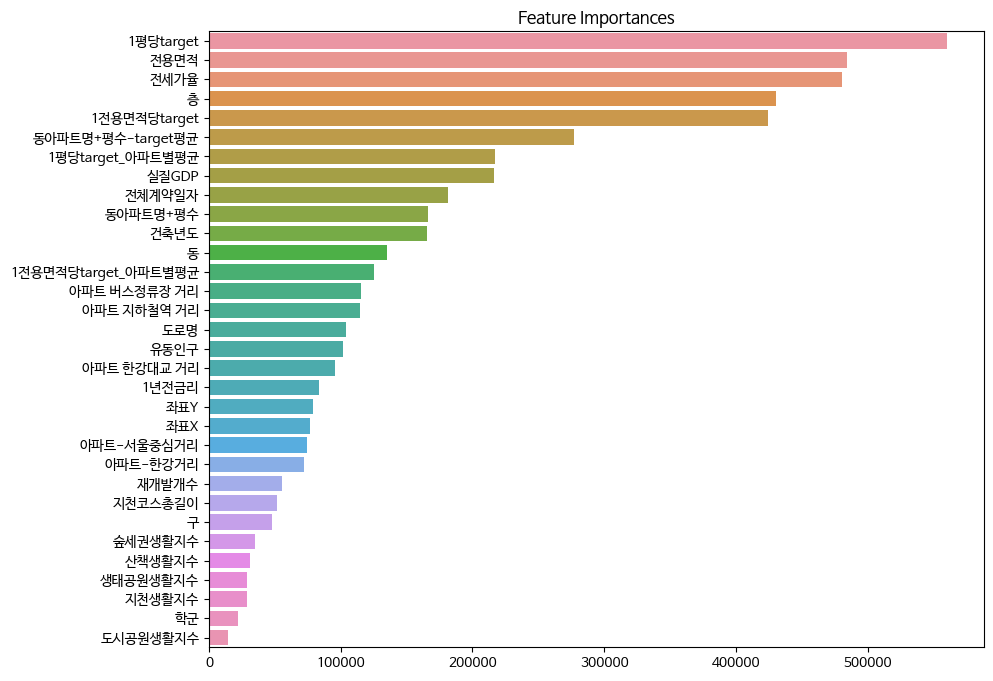

In [103]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [105]:
real_test_pred_upper = np.ceil(real_test_pred, -2)

TypeError: return arrays must be of ArrayType

In [102]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred, columns=["target"])
preds_df.to_csv('output_best_lgbm_model_01251840_1.csv', index=False)

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred_upper, columns=["target"])
preds_df.to_csv('output_best_lgbm_model_01251840_2.csv', index=False)